In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
 
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('/kaggle/input/data-every-day-youtube-episodes/youtube_data.csv')
data

,Video,Video title,Video publish time,End screen element clicks,Comments added,Shares,Likes (vs. dislikes) (%),Dislikes,Likes,Average percentage viewed (%),Average view duration,Views,Watch time (hours),Subscribers,Impressions,Impressions click-through rate (%)
0,7E7tl6rm7VM,100% Accuracy Mushroom Classification - Data E...,23-Aug-20,5,8,36,98.0,1,49,19.96,0:03:17,1429,78.3655,11.0,10910,8.67
1,-46XflOZewg,Bike Share Usage Prediction - Data Every Day #230,28-Mar-21,2,4,1,100.0,0,10,17.55,0:03:31,88,5.1650,0.0,1601,3.37
2,1OHk8urt60A,Tic-Tac-Toe Winner Classification - Data Every...,28-Dec-20,2,3,4,100.0,0,10,17.03,0:04:13,108,7.5958,0.0,2251,2.04
3,4lnUUZxeGBI,Health Insurance Interest Prediction - Data Ev...,17-Sep-20,2,3,6,100.0,0,6,16.01,0:04:21,297,21.5845,5.0,2674,6.28
4,9AnCNBL8c6Q,Age Prediction From Facial Images (CNN Regress...,27-Feb-21,2,5,3,100.0,0,14,20.11,0:04:53,266,21.6983,2.0,3014,5.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,xHKEcMkR9d8,Car Loan Default Prediction (Data Preprocessin...,22-Jan-21,0,0,4,100.0,0,5,12.53,0:06:09,146,14.9656,3.0,2146,3.22
245,xgRxO9iqITI,Pneumonia X-Ray Image Recognition - Data Every...,6-Nov-20,0,3,0,100.0,0,2,16.32,0:04:25,58,4.2834,3.0,1693,1.83
246,y70bUYIPe2A,Dealing With Imbalanced Classes (Forest Cover ...,14-Dec-20,0,3,7,100.0,0,13,12.60,0:04:58,251,20.8134,2.0,5775,2.37
247,yeB59AI2Peo,Predicting Student Grades - Data Every Day #016,26-Aug-20,0,2,5,100.0,0,12,14.26,0:03:27,263,15.1233,4.0,3298,5.12


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Video                               249 non-null    object 
 1   Video title                         249 non-null    object 
 2   Video publish time                  249 non-null    object 
 3   End screen element clicks           249 non-null    int64  
 4   Comments added                      249 non-null    int64  
 5   Shares                              249 non-null    int64  
 6   Likes (vs. dislikes) (%)            249 non-null    float64
 7   Dislikes                            249 non-null    int64  
 8   Likes                               249 non-null    int64  
 9   Average percentage viewed (%)       249 non-null    float64
 10  Average view duration               249 non-null    object 
 11  Views                               249 non-n

In [28]:
## Preprocessing 

def preprocess_input(df):
    df = df.copy()
    
    ## Drop unused column
    df = df.drop(['Video', 'Video title'], axis=1)
    
    ## Drop row with missing target value
    missing_target_row = df[df['Subscribers'].isna()].index
    df = df.drop(missing_target_row, axis=0).reset_index(drop=True)
    
    ## Extract date feature
    df['Video publish time'] = pd.to_datetime(df['Video publish time'])
    df['Video month'] = df['Video publish time'].apply(lambda x: x.month)
    df['Video day'] = df['Video publish time'].apply(lambda x: x.day)
    df = df.drop('Video publish time', axis = 1)
    
    ## Convert duration to seconds
    df['Average view duration'] = pd.to_datetime(df['Average view duration']).apply(lambda x: (x.minute * 60) + x.second) 
    
    ## Split the df into X and y
    X = df.drop('Subscribers', axis=1)
    y = df['Subscribers']
    
    return X, y

In [29]:
X, y = preprocess_input(data)

In [25]:
X

,End screen element clicks,Comments added,Shares,Likes (vs. dislikes) (%),Dislikes,Likes,Average percentage viewed (%),Average view duration,Views,Watch time (hours),Subscribers,Impressions,Impressions click-through rate (%),Video month,Video day
0,5,8,36,98.0,1,49,19.96,197,1429,78.3655,11.0,10910,8.67,8,23
1,2,4,1,100.0,0,10,17.55,211,88,5.1650,0.0,1601,3.37,3,28
2,2,3,4,100.0,0,10,17.03,253,108,7.5958,0.0,2251,2.04,12,28
3,2,3,6,100.0,0,6,16.01,261,297,21.5845,5.0,2674,6.28,9,17
4,2,5,3,100.0,0,14,20.11,293,266,21.6983,2.0,3014,5.14,2,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,0,0,4,100.0,0,5,12.53,369,146,14.9656,3.0,2146,3.22,1,22
244,0,3,0,100.0,0,2,16.32,265,58,4.2834,3.0,1693,1.83,11,6
245,0,3,7,100.0,0,13,12.60,298,251,20.8134,2.0,5775,2.37,12,14
246,0,2,5,100.0,0,12,14.26,207,263,15.1233,4.0,3298,5.12,8,26


In [26]:
X.dtypes

End screen element clicks               int64
Comments added                          int64
Shares                                  int64
Likes (vs. dislikes) (%)              float64
Dislikes                                int64
Likes                                   int64
Average percentage viewed (%)         float64
Average view duration                   int64
Views                                   int64
Watch time (hours)                    float64
Subscribers                           float64
Impressions                             int64
Impressions click-through rate (%)    float64
Video month                             int64
Video day                               int64
dtype: object

In [33]:
rmses = []
r2s = []

kf = KFold(n_splits = 5)

for train_idx, test_idx in kf.split(X):
    X_train = X.iloc[train_idx, :]
    X_test = X.iloc[test_idx, :]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    rmses.append(rmse)
    
    r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
    r2s.append(r2)


In [35]:
print(" RMSE: {:.2f}".format(np.mean(rmses)))
print(" R^2: {:.5f}".format(np.mean(r2s)))

 RMSE: 2.04
 R^2: 0.44456


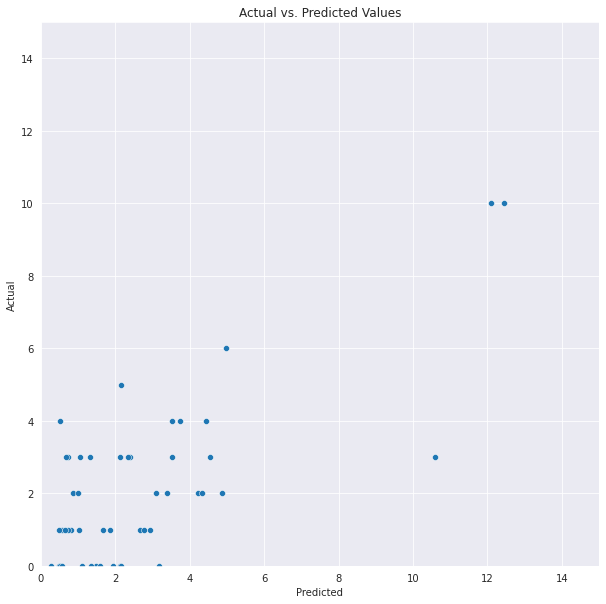

In [40]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = y_pred, y = y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xlim(0,15)
plt.ylim(0,15)
plt.title('Actual vs. Predicted Values')
plt.show()